# Regression
### 1. Reading the Dataset ¶ 

In [21]:
import pandas as pd
df_real_estate = pd.read_csv('real-estate-regression.csv')
df_real_estate.head()

,id,Вулиця,Район,Місто,Область,Дата,Тип нерухомості,Ціна,Тип ціни,Кімнат,...,Загальна площа,Житлова площа,Кухня,Стіни,Назва,Соток,Агенція,Користувач,Телефон,Опис
0,0,Бандеры Степана улица,Галицький,Львів,Львівська,2018-10-12 14:40:23,Квартира,38000,$,2,...,"51,1","15,5","16,5",цегла,NaN,NaN,NaN,Сергій,(095) 521-37-51,Продам 2-х комнатную квартиру по ул. Степана Б...
1,1,Беговая улица,Личаківський,Львів,Львівська,2018-09-10 09:59:47,Квартира,983614,грн,2,...,"65,14","28,69","9,9",монолітно-цегляний,NaN,NaN,ЖК Щасливий,Відділ продажу Щасливий,"(032) 294-94-80, (067) 663-99-51","Подключены коммуникации, интернет, работающие ..."
2,2,"Беговая улица, 17",Личаківський,Львів,Львівська,2018-09-10 10:00:56,Квартира,583730,грн,1,...,"37,66","16,29","9,68",монолітно-цегляний,NaN,NaN,ЖК Щасливий,Відділ продажу Щасливий,"(032) 294-94-80, (067) 663-99-51","Подключены коммуникации, интернет, работающие ..."
3,3,Беговая улица,Личаківський,Львів,Львівська,2018-09-10 10:00:29,Квартира,613211,грн,1,...,"40,61","19,04","9,56",монолітно-цегляний,NaN,NaN,ЖК Щасливий,Відділ продажу Щасливий,"(032) 294-94-80, (067) 663-99-51","Подключены коммуникации, интернет, работающие ..."
4,6,Беговая улица,Личаківський,Львів,Львівська,2018-09-05 15:40:30,Квартира,628160,грн,1,...,"41,6","16,9","10,5",цегла,NaN,NaN,ЖК Щасливий,Відділ продажу Щасливий,"(032) 294-94-80, (067) 663-99-51","Подключены коммуникации, интернет, работающие ..."


### 2. Overview
Columns:
* **id** - id of the data row
* **Вулиця** - the name of the street
* **Район** - the area of the city
* **Місто** - the city
* **Область** - the city area
* **Дата** - the date of the estate being posted on the data base
* **Тип нерухомості** - the type of the real estate
* **Ціна** - the price
* **Тип ціни** - the currency
* **Кімнат** - the number of rooms
* **Поверх** - the floor of the real estate
* **Поверховість** - the number of the floors in the estate
* **Загальна площа** - the area of the estate
* **Житлова площа** - the area of the estate inside
* **Кухня** - the kitchen area
* **Стіни** - the walls material
* **Назва** - the name of the real estate
* **Соток** - the area (1 sotka = 10 x 10 = 100 m2)
* **Агенція** - the agency of the real estate
* **Користувач** - the person or the agency that is selling
* **Телефон** - the phone number
* **Опис** - the description of the real estate

In [71]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# regression models
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.pipeline import Pipeline # for using pipeline
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.preprocessing import PolynomialFeatures # for adding polynomial features
from sklearn.linear_model import Ridge # for ridge regression
from sklearn.linear_model import Lasso # for lasso regression
# from sklearn.svm import SVR # for support vector regression
# from sklearn.tree import DecisionTreeRegressor # for decisiton tree regression
# from sklearn.ensemble import RandomForestRegressor # for random forest regression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
# hyptertuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# extra
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from copy import deepcopy
# from IPython.core.display import display, HTML
# sns.set_style('darkgrid')

### 3. Data Investigation

In [23]:
df_real_estate.count()

id                 1615
Вулиця             1576
Район              1551
Місто              1615
Область            1615
Дата               1615
Тип нерухомості    1615
Ціна               1615
Тип ціни           1615
Кімнат             1615
Поверх             1615
Поверховість       1615
Загальна площа     1615
Житлова площа      1312
Кухня              1392
Стіни              1615
Назва                 0
Соток                 0
Агенція             761
Користувач         1305
Телефон            1615
Опис                674
dtype: int64

We'll change all the currencies to be dollars.

In [24]:
# const
uah = 28.16
df_real_estate.loc[(df_real_estate["Тип ціни"] == '$'), "Ціна"] =\
df_real_estate[df_real_estate['Тип ціни'] == '$']['Ціна'].map(lambda price: uah * price)
df_real_estate.\
drop(['Тип нерухомості', 'Тип ціни', 'Назва', 'Соток', 'id', 'Область', 'Місто', 'Телефон'], axis=1, inplace=True)

We can see that `Назва` and `Соток` can be dropped from the dataset.\
We'll drop the `id` column, because it would spoil the result of the data correlation.\
There is just one city `Lviv` in dataset, so we wouldn't need this column.\
This data only includes houses, like `flat`, so we'll drop column of type of the institution.
All the flats have phone numbers, so we'll drop `Телефон`

In [25]:
df_real_estate.drop(['Агенція', 'Користувач', 'Опис'], axis=1, inplace=True)
df_real_estate.head(3)

,Вулиця,Район,Дата,Ціна,Кімнат,Поверх,Поверховість,Загальна площа,Житлова площа,Кухня,Стіни
0,Бандеры Степана улица,Галицький,2018-10-12 14:40:23,1070080.0,2,5,5,"51,1","15,5","16,5",цегла
1,Беговая улица,Личаківський,2018-09-10 09:59:47,983614.0,2,9,16,"65,14","28,69","9,9",монолітно-цегляний
2,"Беговая улица, 17",Личаківський,2018-09-10 10:00:56,583730.0,1,15,16,"37,66","16,29","9,68",монолітно-цегляний


In [26]:
def col_to_float(df_c, name):
    return df_c[name].\
    map(lambda area: float(area.replace(',', '.')) if isinstance(area, str) else area)

df_real_estate['Загальна площа'] = col_to_float(df_real_estate, 'Загальна площа')
df_real_estate['Житлова площа'] = col_to_float(df_real_estate, 'Житлова площа')
df_real_estate['Кухня'] = col_to_float(df_real_estate, 'Кухня')
df_real_estate['price_per_m'] = round(df_real_estate['Ціна']/df_real_estate['Загальна площа'], 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5a6d6b490>,
      dtype=object)

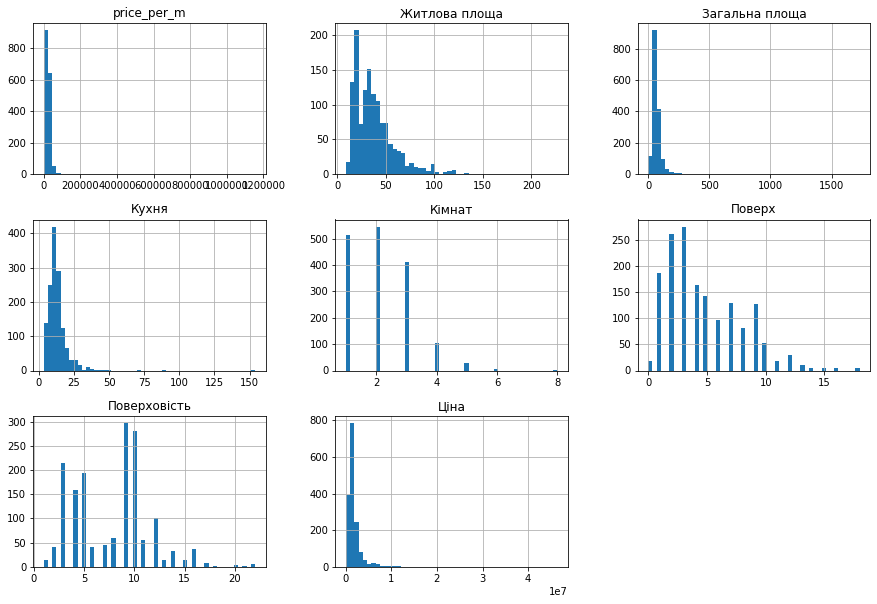

In [27]:
df_real_estate.hist(bins=50,figsize=(15,10))

Better for the linear regrssion is to remove `Поверховість`, us it makes the linear regression hesitate about the line.

In [28]:
df_real_estate.drop(['Поверховість'], axis=1, inplace=True)

### Remove null values

In [29]:
df_real_estate.isnull().sum()

Вулиця             39
Район              64
Дата                0
Ціна                0
Кімнат              0
Поверх              0
Загальна площа      0
Житлова площа     303
Кухня             223
Стіни               0
price_per_m         0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5a5fff490>]],
      dtype=object)

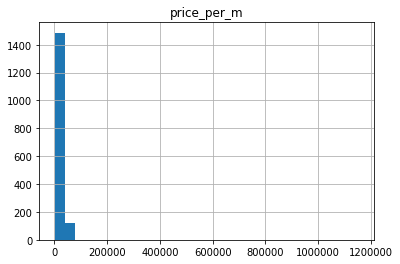

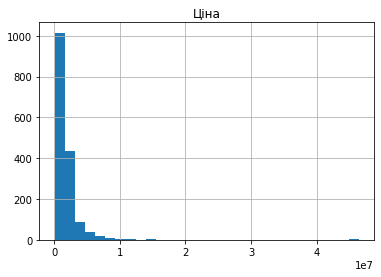

In [30]:
df_real_estate.hist(column='price_per_m',bins=30)
df_real_estate.hist(column='Ціна',bins=30)

As the distributions of `price_per_m` and `Ціна` are skewed, it's better to replace `null` values by **median**. (sklearn's Imputer)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5a76c7190>]],
      dtype=object)

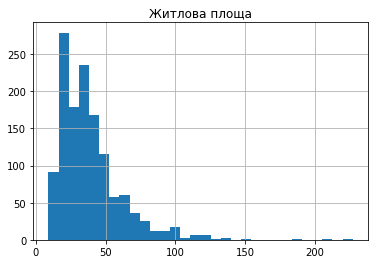

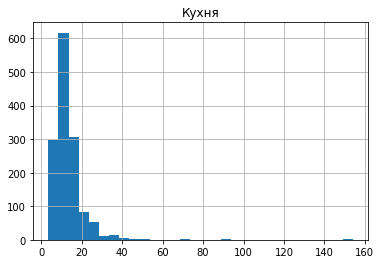

In [31]:
df_real_estate.hist(column='Житлова площа',bins=30)
df_real_estate.hist(column='Кухня',bins=30)

In [32]:
in_area = SimpleImputer(missing_values=np.nan, strategy='median')
df_real_estate[['Житлова площа']] = in_area.fit_transform(df_real_estate[['Житлова площа']])
df_real_estate[['Кухня']] = in_area.fit_transform(df_real_estate[['Кухня']])

In [33]:
df_real_estate.drop(['Вулиця'], axis=1, inplace=True)
df_real_estate = df_real_estate[df_real_estate['Район'].notna()]

In [34]:
df_real_estate.isnull().sum()

Район             0
Дата              0
Ціна              0
Кімнат            0
Поверх            0
Загальна площа    0
Житлова площа     0
Кухня             0
Стіни             0
price_per_m       0
dtype: int64

### Removing outliers

In [35]:
num_features=['Ціна', 'Кімнат', 'Поверх', 'Загальна площа', 'Житлова площа', 'Кухня', 'price_per_m']

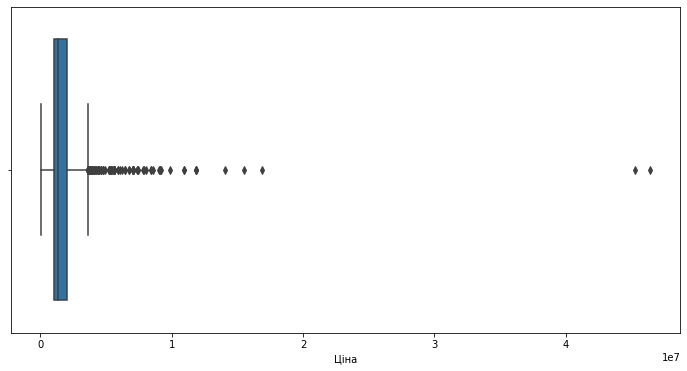

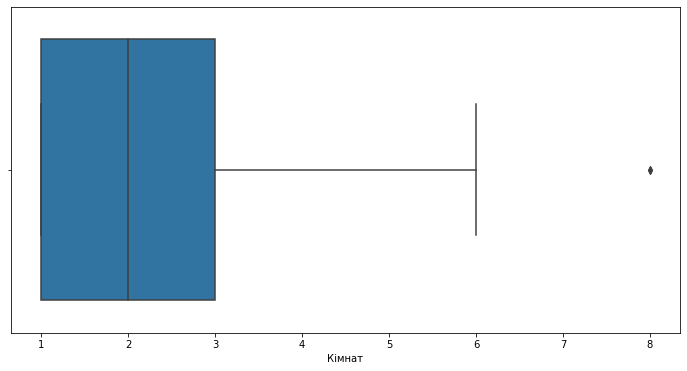

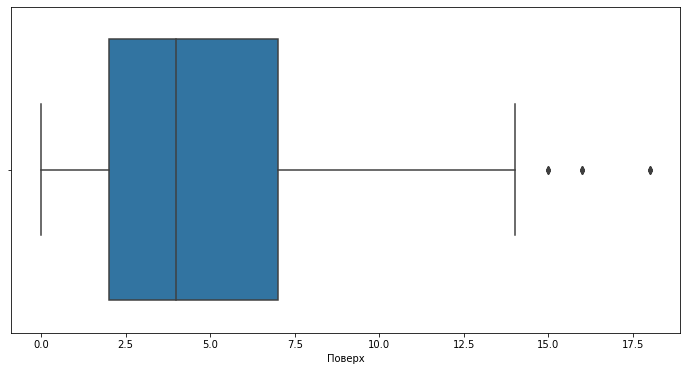

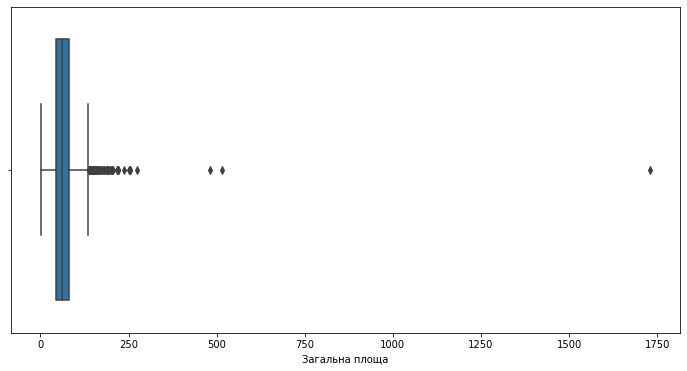

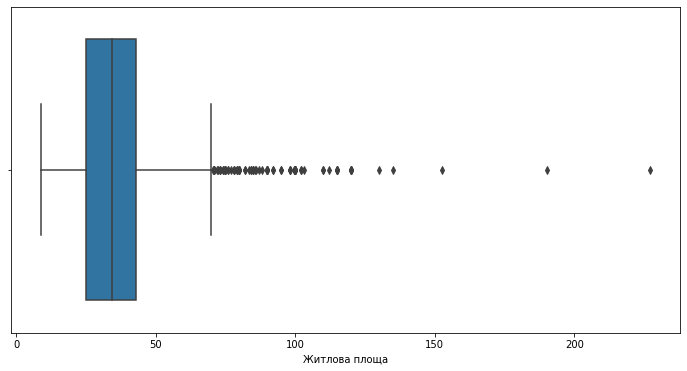

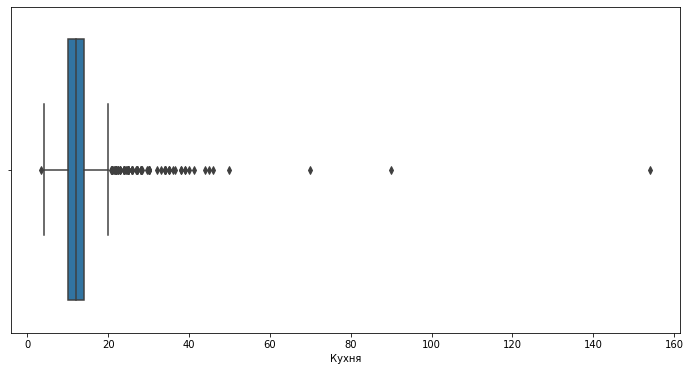

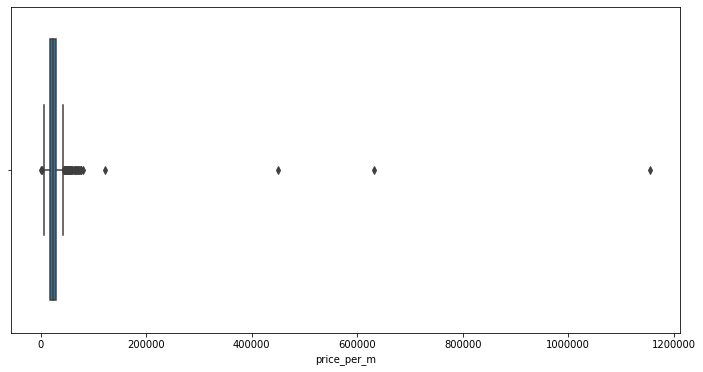

In [36]:
for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    #plt.xlim(-10,10)
    sns.boxplot(x=i, data=df_real_estate, ax=ax)

In [42]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """
    def fit (self,X,y=None):
        return self

    def transform(self,X,y=None):
        X=X[(X['Кімнат']<=6)].reset_index(drop=True)
        X=X[(X['Загальна площа']<=300)].reset_index(drop=True)
        X=X[(X['Житлова площа']<=150)].reset_index(drop=True)
        X=X[(X['Кухня']<=60)].reset_index(drop=True)
        X=X[X['price_per_m']<150000].reset_index(drop=True)
        return X

In [43]:
df_real_estate = RemoveOutliers().fit_transform(df_real_estate)
df_real_estate.drop(['Ціна'], axis=1, inplace=True)
df_labels = df_real_estate['price_per_m']
df = df_real_estate.drop(['price_per_m'], axis=1)

KeyError: "['Ціна'] not found in axis"

In [44]:
df_real_estate.head()

,Район,Дата,Кімнат,Поверх,Загальна площа,Житлова площа,Кухня,Стіни,price_per_m
0,Галицький,2018-10-12 14:40:23,2,5,51.10,15.50,16.50,цегла,20940.9
1,Личаківський,2018-09-10 09:59:47,2,9,65.14,28.69,9.90,монолітно-цегляний,15100.0
2,Личаківський,2018-09-10 10:00:56,1,15,37.66,16.29,9.68,монолітно-цегляний,15500.0
3,Личаківський,2018-09-10 10:00:29,1,12,40.61,19.04,9.56,монолітно-цегляний,15100.0
4,Личаківський,2018-09-05 15:40:30,1,6,41.60,16.90,10.50,цегла,15100.0


### Transforming skewed features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb58868d290>,
      dtype=object)

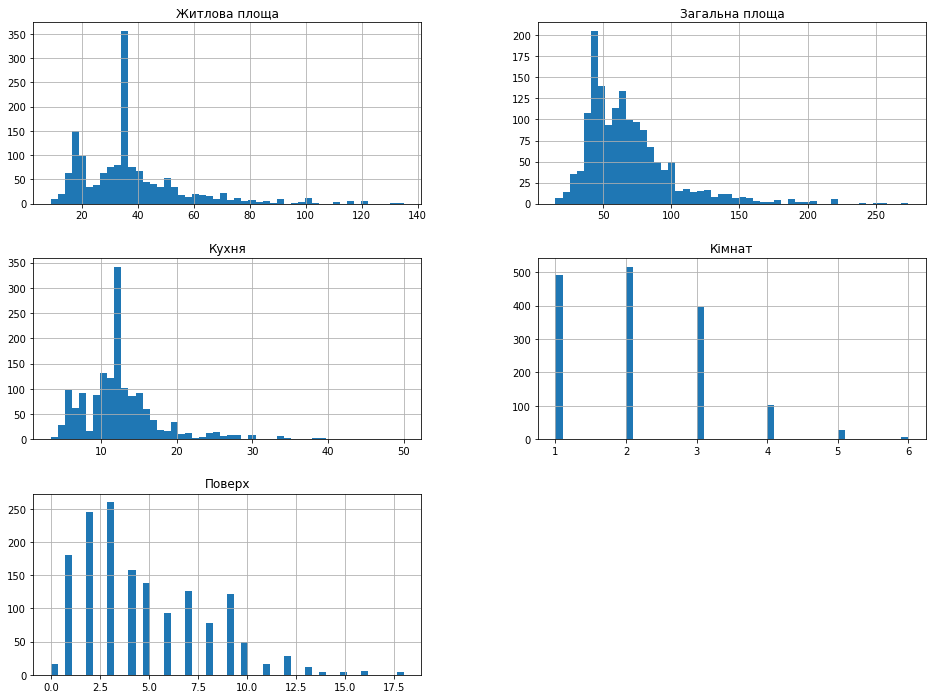

In [45]:
df.hist(bins=50,figsize=(16,12))

In [46]:
skew_features = ['Кухня', 'Загальна площа', 'Житлова площа']

Get skewness of features

In [47]:
skewness= []
for i in skew_features:
    skewness.append(df[i].skew())
pd.DataFrame(data=skewness, index=skew_features, columns=['skewness']).sort_values(by='skewness',ascending=False)

,skewness
Кухня,2.074858
Загальна площа,1.914157
Житлова площа,1.680670


In [48]:
class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        import numpy as np
        from scipy.special import boxcox1p        
        X['Кухня']=X['Кухня'].apply(lambda x: np.log1p(x)**0.5)
        X['Загальна площа']=X['Загальна площа'].apply(lambda x: np.log1p(x)**0.5)
        X['Житлова площа']=X['Житлова площа'].apply(lambda x: np.log1p(x)**0.3)
        return X

In [49]:
df = FeaturesTransformer().fit_transform(df)

#### Transformed features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5a5fa8e90>,
      dtype=object)

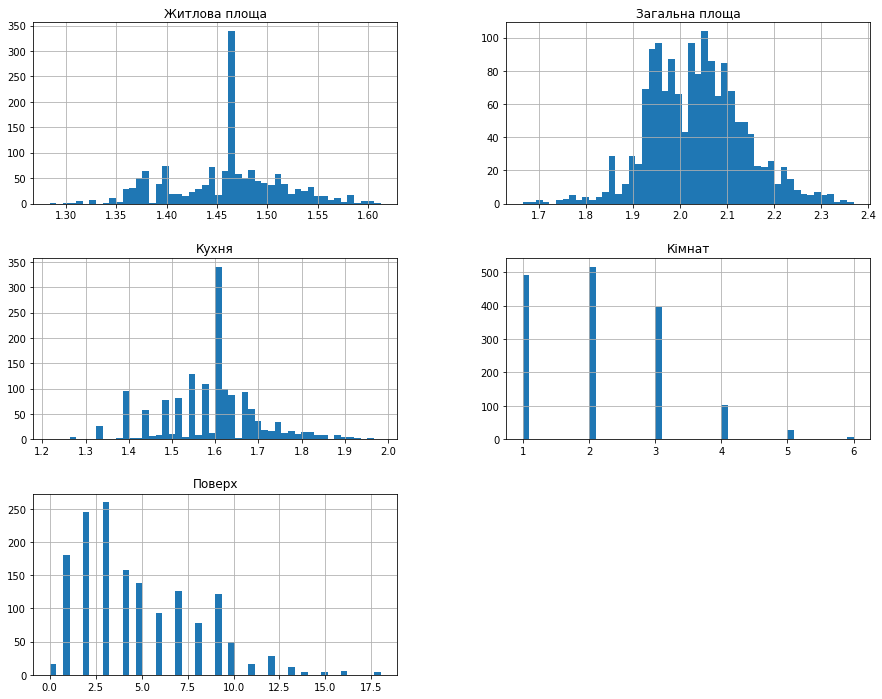

In [50]:
df.hist(bins=50,figsize=(15,12))

## Group string variables

##### Deal with walls

We have to divide the walls into different categories to know their impact on the outcome.

In [51]:
d_walls = {}
for i, wall in enumerate(set(df_real_estate['Стіни'])):
    if wall is not np.nan:
        wall = wall.strip()
        if wall in ['армированный железобетон', 'газобетон', 'газоблок', 'монолітно-блоковий', 'піноблок',\
                    'залізобетон', 'керамзитобетон', 'сборный железобетон', 'керамический блок', 'панель',\
                    'сборный железобетон']:
            d_walls[wall] = 'Блоки'
        elif wall in ['монолитно-каркасный', 'монолитный железобетон', 'моноліт']:
            d_walls[wall] = 'Моноліт'
        elif wall in ['керамический кирпич', 'монолітно-цегляний', 'силікатна цегла', 'цегла']:
            d_walls[wall] = 'Цегла'
df_real_estate['Стіни'] = df_real_estate['Стіни'].map(lambda wall: d_walls[wall.strip()])

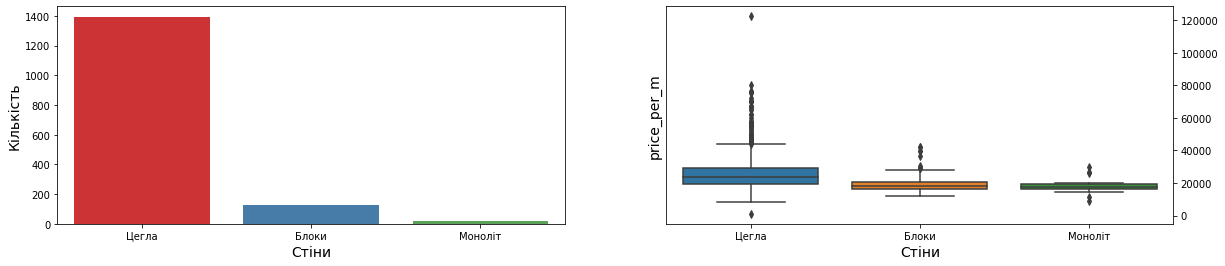

In [52]:
f, axes = plt.subplots(1,2,figsize=(20,4))

sns.countplot(df_real_estate['Стіни'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Стіни', fontsize=14)
axes[0].set_ylabel('Кількість', fontsize=14)
axes[0].yaxis.tick_left()

sns.boxplot(x=df_real_estate['Стіни'], y=df_real_estate['price_per_m'], data=df_real_estate, ax=axes[1])
axes[1].set_xlabel('Стіни', fontsize=14)
axes[1].set_ylabel('price_per_m', fontsize=14)
axes[1].yaxis.tick_right()

plt.show()

Usually there are used `цегла`, we would better drop this column.

In [53]:
df.drop(['Стіни'], axis=1, inplace=True)
df_real_estate.drop(['Стіни'], axis=1, inplace=True)

In [54]:
df.head()

,Район,Дата,Кімнат,Поверх,Загальна площа,Житлова площа,Кухня
0,Галицький,2018-10-12 14:40:23,2,5,1.988257,1.362397,1.691804
1,Личаківський,2018-09-10 09:59:47,2,9,2.047382,1.442418,1.545562
2,Личаківський,2018-09-10 10:00:56,1,15,1.911755,1.369176,1.538952
3,Личаківський,2018-09-10 10:00:29,1,12,1.930891,1.390074,1.535276
4,Личаківський,2018-09-05 15:40:30,1,6,1.936970,1.374152,1.562801


##### Deal with districts

We have too many districts in the dataset, so we'll mannualy divide them into 7 cathegories.

In [55]:
d_area = {}
for i, area in enumerate(set(df_real_estate['Район'])):
    if area is not np.nan:
        if area in ['Новий Львів', 'Санта Барбара', 'Сихівський', 'Сыховский', 'Боднаровка', 'Бондарівка']:
            d_area[area] = 'Сихів'
        elif area in ['Галицький', 'Площа Ринок']:
            d_area[area] = 'Галицький'
        elif area in ['Замарстинів', 'Шевченківський', 'Голоско']:
            d_area[area] = 'Шевченківський'
        elif area in ['Залізничний', 'Левандівка']:
            d_area[area] = 'Залізничний'
        elif area in ['Личаків', 'Личаківський', 'Погулянка', 'Майорівка']:
            d_area[area] = 'Личаків'
        elif area in ['Наукова', 'Франковск��й', 'Франківський']:
            d_area[area] = 'Франківський'
        elif area in ['Рудне', 'Брюховичі', 'Зимна Вода', 'Рясне', 'Скнилів', 'Сокільники', 'Винники']:
            d_area[area] = 'Села'
    else:
        d_area[area] = (df_real_estate['Район']).value_counts().idxmax()

df_real_estate['Район'] = df_real_estate['Район'].map(lambda area: d_area[area])

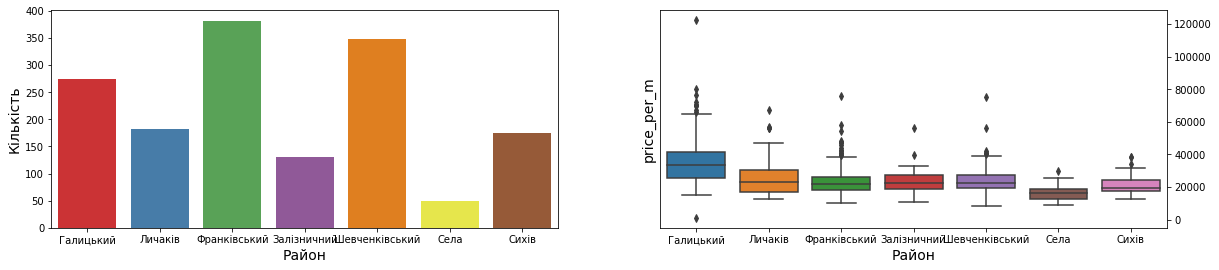

In [56]:
f, axes = plt.subplots(1,2,figsize=(20,4))

sns.countplot(df_real_estate['Район'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Район', fontsize=14)
axes[0].set_ylabel('Кількість', fontsize=14)
axes[0].yaxis.tick_left()

sns.boxplot(x=df_real_estate['Район'], y=df_real_estate['price_per_m'], data=df_real_estate, ax=axes[1])
axes[1].set_xlabel('Район', fontsize=14)
axes[1].set_ylabel('price_per_m', fontsize=14)
axes[1].yaxis.tick_right()

plt.show()

In [57]:
df['Район'] = df_real_estate['Район']
df_labels['Район'] = df_real_estate['Район'].copy()

### The correlation of the data

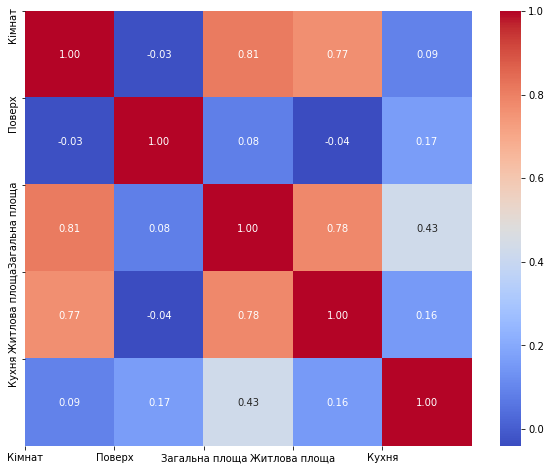

In [58]:
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [59]:
df.drop(['Кухня', 'Дата'], axis=1, inplace=True)

In [60]:
df.count()

Район             1541
Кімнат            1541
Поверх            1541
Загальна площа    1541
Житлова площа     1541
dtype: int64

In [61]:
df.describe()

,Кімнат,Поверх,Загальна площа,Житлова площа
count,1541.000000,1541.000000,1541.000000,1541.000000
mean,2.142764,4.787800,2.035521,1.459263
std,1.025833,3.208108,0.101652,0.055687
min,1.000000,0.000000,1.665109,1.284295
25%,1.000000,2.000000,1.956691,1.425244
50%,2.000000,4.000000,2.035469,1.464817
75%,3.000000,7.000000,2.099219,1.490706
max,6.000000,18.000000,2.369973,1.612111


In [62]:
df.isnull().sum()

Район             0
Кімнат            0
Поверх            0
Загальна площа    0
Житлова площа     0
dtype: int64

### Get dummies and Scale the labels

In [63]:
df = pd.get_dummies(df)

In [64]:
df.head()

,Кімнат,Поверх,Загальна площа,Житлова площа,Район_Галицький,Район_Залізничний,Район_Личаків,Район_Села,Район_Сихів,Район_Франківський,Район_Шевченківський
0,2,5,1.988257,1.362397,1,0,0,0,0,0,0
1,2,9,2.047382,1.442418,0,0,1,0,0,0,0
2,1,15,1.911755,1.369176,0,0,1,0,0,0,0
3,1,12,1.930891,1.390074,0,0,1,0,0,0,0
4,1,6,1.936970,1.374152,0,0,1,0,0,0,0


In [65]:
label_scaler = StandardScaler()
df_labels = label_scaler.fit_transform(df_labels[:-1].values.reshape(-1,1))

In [66]:
print(len(df), len(df_labels))

1541 1541


In [67]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, shuffle=True, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.25, random_state=1)

In [68]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of X_val: ",X_val.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_val",y_val.shape)

Shape of X_train:  (924, 11)
Shape of X_test:  (309, 11)
Shape of X_val:  (308, 11)
Shape of y_train:  (924, 1)
Shape of y_test (309, 1)
Shape of y_val (308, 1)


### Regression Model
#### Linear Regression

In [72]:
X_train1, X_test1, y_train1, y_test1 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)
linear_model = LinearRegression()
model1 = linear_model.fit(X_train1, y_train1)
predictions1 = linear_model.predict(X_test1)

Text(0, 0.5, 'Predictions')

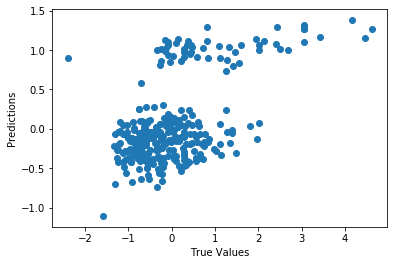

In [73]:
## The line / model
plt.scatter(y_test1, predictions1)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [74]:
print('Score:', model.score(X_test1, y_test1))

Score: 0.3259831324825525


In [77]:
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator=lm, X=df, y=df_labels, cv=8)

# Predicting R2 Score the Train set results
y_pred_linear_train1 = lm.predict(X_train1)
r2_score_linear_train1 = r2_score(y_train1, y_pred_linear_train1)

# Predicting R2 Score the Test set results
y_pred_linear_test1 = lm.predict(X_test1)
r2_score_linear_test1 = r2_score(y_test1, y_pred_linear_test1)

# Predicting RMSE the Test set results
# Root Mean Squere Error
rmse_linear1 = (np.sqrt(mean_squared_error(y_test1, y_pred_linear_test1)))
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_linear_train1)
print('R2_score (test): ', r2_score_linear_test1)
print("RMSE: ", rmse_linear1)

CV:  0.2555051843821778
R2_score (train):  0.2769412021053542
R2_score (test):  0.3259831324825525
RMSE:  0.8219833759948861


### Ridge Regression

In [82]:
X_train2, X_test2, y_train2, y_test2 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso())
]

lasso_pipe = Pipeline(steps)
# Applying Grid Search to find the best model and the best parameters
# step 1: alpha:np.arange(0.01, 1, 0.005) -> 0.9949

parameters =  {'model__alpha' : [43],
               'model__fit_intercept' : [True],
               'model__tol' : [0.0001],
               'model__max_iter' : [5000],
               'model__random_state': [42]
}
regressor_ridge = GridSearchCV(lasso_pipe, parameters, iid=False, cv=10)
regressor_ridge = regressor_ridge.fit(X_train2, y_train2.ravel())

# Predicting Cross Validation Score
cv_ridge = regressor_ridge.best_score_

/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [84]:
# Predicting R2 Score the Test set results
y_pred_ridge_train2 = regressor_ridge.predict(X_train2)
r2_score_ridge_train2 = r2_score(y_train2, y_pred_ridge_train2)

# Predicting R2 Score the Test set results
y_pred_ridge_test2 = regressor_ridge.predict(X_test2)
r2_score_ridge_test2 = r2_score(y_test2, y_pred_ridge_test2)

# Predicting RMSE the Test set results
rmse_ridge2 = (np.sqrt(mean_squared_error(y_test2, y_pred_ridge_test2)))
print('CV: ', cv_ridge.mean())
print('R2_score (train): ', r2_score_ridge_train2)
print('R2_score (test): ', r2_score_ridge_test2)
print("RMSE: ", rmse_ridge2)

CV:  -0.015665525478069587
R2_score (train):  0.0
R2_score (test):  -4.6147347908753744e-05
RMSE:  1.0012388030403312


### Lasso Regresion

In [85]:
X_train3, X_test3, y_train3, y_test3 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso())
]

lasso_pipe = Pipeline(steps)
# Applying Grid Search to find the best model and the best parameters
# step 1: alpha:np.arange(0.01, 1, 0.005) -> 0.9949

parameters =  {'model__alpha' : [0.9949],
               'model__fit_intercept' : [True], 'model__tol' : [0.0001],
               'model__max_iter' : [5000], 'model__random_state': [42] 
}
regressor_lasso = GridSearchCV(lasso_pipe, parameters, iid=False, cv=10, n_jobs = -1, verbose = 4)
regressor_lasso = regressor_lasso.fit(X_train3, y_train3.ravel())

# Predicting Cross Validation Score
cv_lasso = regressor_lasso.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [86]:
# Predicting R2 Score the Test set results
y_pred_lasso_train3 = regressor_lasso.predict(X_train3)
r2_score_lasso_train3 = r2_score(y_train3, y_pred_lasso_train3)

# Predicting R2 Score the Test set results
y_pred_lasso_test3 = regressor_lasso.predict(X_test3)
r2_score_lasso_test3 = r2_score(y_test3, y_pred_lasso_test3)

# Predicting RMSE the Test set results
rmse_lasso3 = (np.sqrt(mean_squared_error(y_test3, y_pred_lasso_test3)))
print('CV: ', cv_lasso.mean())
print('R2_score (train): ', r2_score_lasso_train3)
print('R2_score (test): ', r2_score_lasso_test3)
print("RMSE: ", rmse_lasso3)

CV:  -0.015665525478069587
R2_score (train):  0.0
R2_score (test):  -4.6147347908753744e-05
RMSE:  1.0012388030403312
